In [1]:
!mkdir images/

In [22]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tqdm.notebook import tqdm
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMG_ROWS = 28
IMG_COLS = 28
CHANNELS = 1
IMAGE_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)

In [12]:
def build_discriminator():
    
    model = models.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    
    img = Input(shape=IMAGE_SHAPE)
    validity = model(img)
    
    return Model(img, validity)

In [17]:
def build_generator():
    NOISE_SHAPE = (100, )

    model = models.Sequential()

    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=NOISE_SHAPE))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    model.summary()
    
    noise = Input(shape=NOISE_SHAPE)
    img = model(noise)
    
    return Model(noise, img)

In [26]:
def train(epochs, batch_size=128, save_interval=50):
    
    (X_train, _), (_, _) = mnist.load_data()
    
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    
    X_train = np.expand_dims(X_train, axis=3)
    
    half_batch = int(batch_size / 2)
    
    for epoch in tqdm(range(epochs)):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        
        noise = np.random.normal(0, 1, (half_batch, 100)) # fake data
        
        gen_imgs = generator.predict(noise, verbose=0)
        
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        
        valid_y = np.array([1]* batch_size)
        
        g_loss = combined.train_on_batch(noise, valid_y)
        
        if epoch % 100 == 0:
            print(f"\nEpoch {epoch}: [D Loss: {d_loss[0]}] [G Loss: {g_loss}]")
        
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [27]:
def save_imgs(epoch):
    r, c = 5, 5
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            noise = np.random.normal(0, 1, (r * c, 100))
            gen_imgs = generator.predict(noise, verbose=0)

            gen_imgs = 0.5 * gen_imgs + 0.5
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"/kaggle/working/images/mnist_{epoch}.png")
    plt.close()

In [28]:
optimizer = Adam(learning_rate=0.0001)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=6000, batch_size=32, save_interval=200)

generator.save('generator_model_test.h5')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)             

  0%|          | 0/6000 [00:00<?, ?it/s]

2024-04-29 03:14:05.900371: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/sequential_8/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-29 03:14:06.636059: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/model_8/sequential_8/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 0: [D Loss: 0.7007984519004822] [G Loss: 0.6701236367225647]

Epoch 100: [D Loss: 0.3780617415904999] [G Loss: 0.01781320944428444]

Epoch 200: [D Loss: 0.0029781601042486727] [G Loss: 0.0018726798007264733]

Epoch 300: [D Loss: 0.002061925712041557] [G Loss: 0.0008152314112521708]

Epoch 400: [D Loss: 0.048130049370229244] [G Loss: 0.0032180435955524445]

Epoch 500: [D Loss: 0.03828341327607632] [G Loss: 0.00787934847176075]

Epoch 600: [D Loss: 0.32263947278261185] [G Loss: 0.16428488492965698]

Epoch 700: [D Loss: 0.08179177716374397] [G Loss: 0.09694664180278778]

Epoch 800: [D Loss: 0.5778158903121948] [G Loss: 2.438977003097534]

Epoch 900: [D Loss: 0.56279057264328] [G Loss: 0.8028193116188049]

Epoch 1000: [D Loss: 0.7839989960193634] [G Loss: 1.5257267951965332]

Epoch 1100: [D Loss: 0.7651896774768829] [G Loss: 0.7910350561141968]

Epoch 1200: [D Loss: 0.7982576191425323] [G Loss: 0.8696697950363159]

Epoch 1300: [D Loss: 0.46632029116153717] [G Loss: 0.638349831104278

In [29]:
from tensorflow.keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

In [30]:
model = load_model('/kaggle/working/generator_model_test.h5')

1/1 [==============================] - 0s 18ms/step


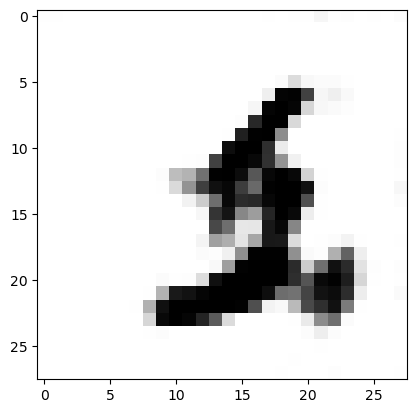

In [47]:
vector = randn(100)
vector = vector.reshape(1, 100)

X = model.predict(vector)

pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()